In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class AR():
    """
    Class for simulation of lightcurves using autoregressive model (DRW)
    """
    def __init__(self, order, alpha, N, mean):
        """
        Parameters
        ----------
        order : int
            order of autoregressive model. CAR1 has order 2
        alpha : list
            array of alpha values
        N : int
            length of 
        """
        self.alpha = alpha
        self.N = N
        self.t = range(N)
        self.mean = mean
        self.order = order
        
        
    def run(self):
        x = np.full(self.N, self.mean, dtype='float64')
        Z = np.random.normal(0, 0.5, size=self.N)
        
        if self.order == 1:
            for i in range(self.N-1):
                x[i+1] = self.alpha * x[i] + Z[i]
        if self.order == 2:
            ARmean = self.mean/(1 - self.alpha[0] - self.alpha[1])
            x[0] = ARmean
            x[1] = ARmean
            for i in range(self.N-2):
                x[i+2] = self.alpha[1] * x[i+1] + self.alpha[0] * x[i] + Z[i] + self.mean
            
        self.x = x
        
    def plot_series(self):
        fig, ax = plt.subplots(1,1, figsize=(20,10))
        ax.plot(self.x)
    
    def compute_dtdm(self):
        """
        desc

        Parameters
        ----------
        param : type
            desc

        Returns
        -------
        value : type
            desc
        """
        
        mjd_mag = np.array([self.t, self.x]).T
        dtdm = mjd_mag - mjd_mag[:,np.newaxis,:]
        dtdm = dtdm[np.triu_indices(self.N,1)]
        dtdm = dtdm*np.sign(dtdm[:,0])[:,np.newaxis]
        self.dtdm = dtdm
        
    def bin_dtdm(self):
        n_bins_t = 100
        n_bins_m = 100
        
#         dts_binned = np.zeros((n_bins_t), dtype='int64')
#         dms_binned = np.zeros((n_bins_m), dtype='int64')
        self.t_bin_edges = np.linspace(0, self.N, n_bins_t+1)
#         self.t_bin_chunk = np.linspace(0, self.N, 21)
        self.t_bin_chunk = np.logspace(-3, np.log10(self.N), 21)
        self.m_bin_edges = np.linspace(-3, 3, n_bins_m+1)
        self.m_bin_centres = (self.m_bin_edges[1:] + self.m_bin_edges[:-1])/2
        self.t_bin_chunk_centres = (self.t_bin_chunk[1:] + self.t_bin_chunk[:-1])/2
        
        n_t_chunk = len(self.t_bin_chunk)
        dts_binned = np.zeros((n_t_chunk,n_bins_t), dtype = 'int64')
        dms_binned = np.zeros((n_t_chunk,n_bins_m), dtype = 'int64')
        
        dtdms = [np.empty((0,2))]*n_t_chunk
        idxs = np.digitize(self.dtdm[:,0], self.t_bin_chunk)-1
        
        for index in np.unique(idxs): #Can we vectorize this?
            dtdms[index] = np.append(dtdms[index],self.dtdm[(idxs == index),:],axis = 0)

    # Bin up the data within each time chunk
        for i in range(n_t_chunk):
    #		 print('dtdm counts in {}: {:,}'.format(t_dict[i],len(dtdms[i])))
            dts_binned[i] = np.histogram(dtdms[i][:,0], self.t_bin_edges)[0]
            dms_binned[i] = np.histogram(dtdms[i][:,1], self.m_bin_edges)[0]

        self.dts_binned = dts_binned
        self.dms_binned = dms_binned
        
    def plot_SF(self):
        fig, ax = plt.subplots(1,1, figsize=(15,8))
        SF = (((self.m_bin_centres**2)*self.dms_binned).sum(axis=1)/self.dms_binned.sum(axis=1))**0.5
        
        ax.set(yscale='log',xscale='log')
        ax.set(xlabel='∆t',ylabel = 'structure function')
        ax.scatter(self.t_bin_chunk_centres, SF[:-1])
        
        self.SF = SF
        
    def hist_dm(self, window_width, save=False):

        # 		cmap = plt.cm.cool
        fig, axes = plt.subplots(19,1,figsize = (15,3*19))
        n=1
        for i, ax in enumerate(axes):
            m,_,_= ax.hist(self.m_bin_edges[:-1], self.m_bin_edges[::n], weights = self.dms_binned[i], alpha = 1, density=False)#, label = self.t_dict[i], color = cmap(i/20.0));
            ax.set(xlim=[0,window_width], xlabel='∆σ')
            ax.axvline(x=0, lw=0.5, ls='--')
            ax.legend()

    

In [8]:
dts_binned_tot = np.zeros((21, 100), dtype = 'int64')
dms_binned_tot = np.zeros((21, 100), dtype = 'int64')
for i in range(10):
    ar1 = AR(2, [0.53,0.469], 100, 5)
    ar1.run()
    ar1.compute_dtdm()
    ar1.bin_dtdm()
    dts_binned_tot += ar1.dts_binned
    dms_binned_tot += ar1.dms_binned

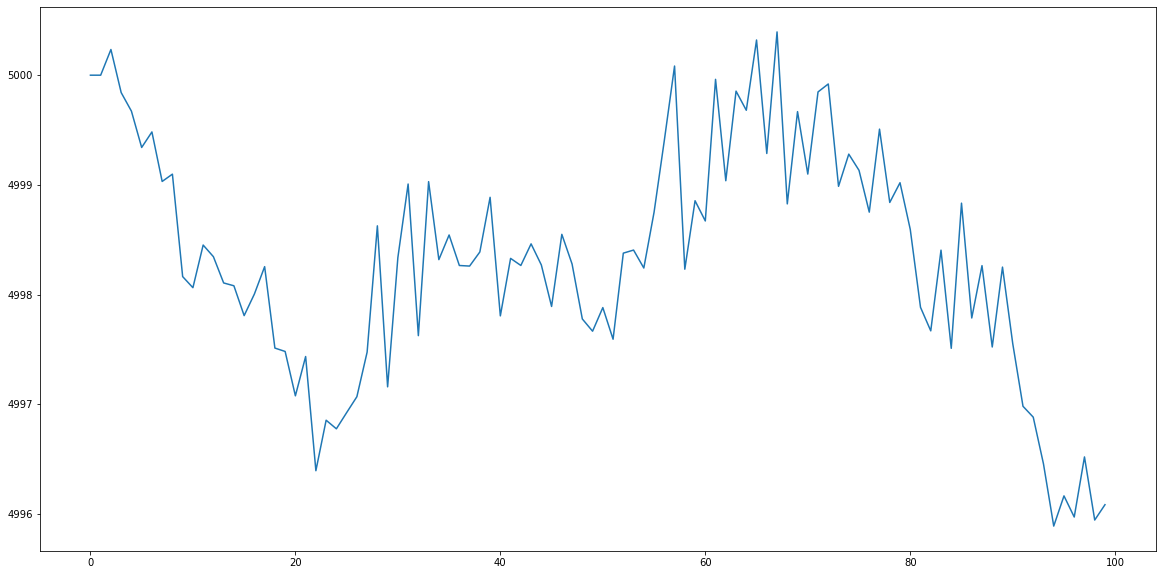

In [9]:
ar1.plot_series()

In [10]:
ar_tot = AR(2, [0.53,0.469], 100, 5)
ar_tot.run()
ar_tot.compute_dtdm()
ar_tot.bin_dtdm()
ar_tot.dms_binned = dms_binned_tot
ar_tot.dts_binned = dts_binned_tot


/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


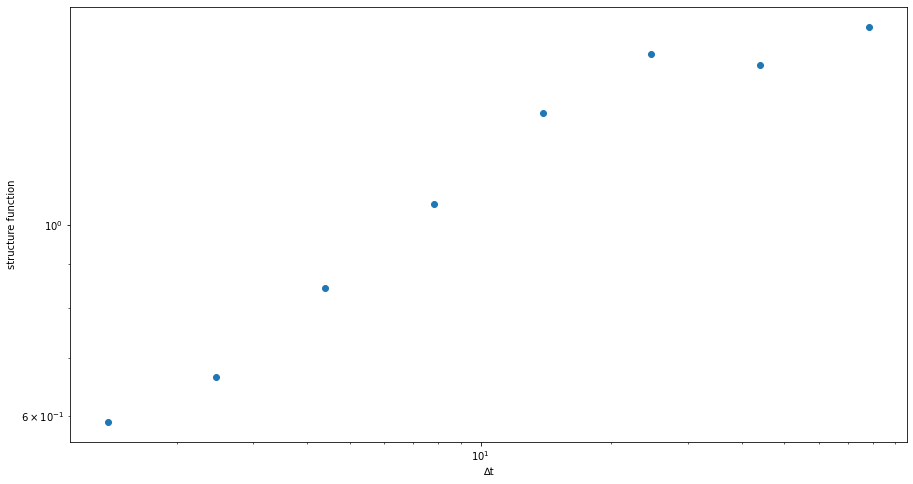

In [11]:
ar_tot.plot_SF()

In [12]:
ar_tot.dtdm

array([[1.        , 0.        ],
       [2.        , 1.11310875],
       [3.        , 0.27340161],
       ...,
       [1.        , 0.0279384 ],
       [2.        , 0.06054955],
       [1.        , 0.03261115]])